In [1]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import pprint
import torch

In [2]:
# Arguments
args = Namespace(
    seed=999,
    num_samples_per_class=50,
    dimensions=2,
    num_classes=3,
    train_size=0.8,
    test_size=0.2,
    num_hidden_units=200,
    learning_rate=1e-0,
    regularization=1e-3,
    num_epochs=500,
    dropout_p = 0.1,
    lamda_l2 = 1e-5
)

# Set seed for reproducability
np.random.seed(args.seed)
pprint.pprint(vars(args),indent = 4)

{   'dimensions': 2,
    'dropout_p': 0.1,
    'lamda_l2': 1e-05,
    'learning_rate': 1.0,
    'num_classes': 3,
    'num_epochs': 500,
    'num_hidden_units': 200,
    'num_samples_per_class': 50,
    'regularization': 0.001,
    'seed': 999,
    'test_size': 0.2,
    'train_size': 0.8}


In [3]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j,num_samples_per_class*(j+1))
        #r = np.linspace(0.0,1,num_samples_per_class) # radius
        r = np.random.normal(0.6,0.3,num_samples_per_class)
        theta = 2*np.pi / num_classes
        t = np.linspace(j*theta,(j+1)*theta,num_samples_per_class) + \
        np.random.randn(num_samples_per_class)*0.5 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    # Stack
    print(np.shape(X_original))
    X = np.hstack([X_original])
    return X, y

In [4]:
# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
                     dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

(150, 2)
X: (150, 2)
y: (150,)


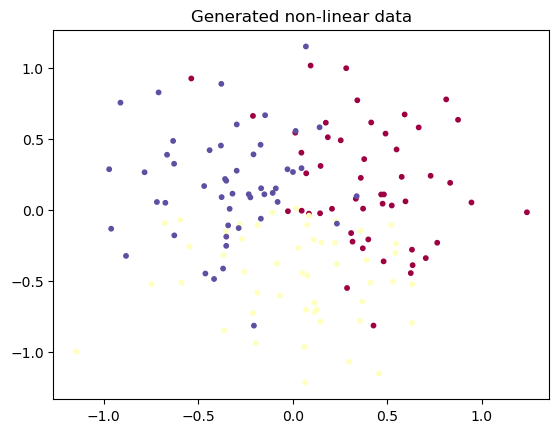

In [5]:
# Visualize data
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.Spectral)
plt.show()

In [6]:
print(type(X),type(y))
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
print(X.type(),y.type())
#print(X)
#print(y)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
torch.FloatTensor torch.LongTensor


In [7]:
z = random.sample(range(0,len(X)),len(X))
s_index = torch.LongTensor(z)
#print(z)
X = X[s_index]
y = y[s_index]
test_index_s = int(len(X) * args.train_size)
#print(test_index_s)
X_train = X[:test_index_s]
y_train = y[:test_index_s]
X_test = X[test_index_s:]
y_test = y[test_index_s:]
print("This case contians %i train samples and %i test samples" % (len(X_train), len(y_test)))

This case contians 120 train samples and 30 test samples


In [8]:
# test for a liner model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [9]:
class LogisticClassifier(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(LogisticClassifier,self).__init__()#get init func from nn.Module
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)

    def forward(self,x_in,apply_Softmax = False):
        a_1 = self.fc1(x_in)
        a_2 = self.fc2(a_1)
        y_pred = self.fc3(a_2)

        if apply_Softmax :
            y_pred = F.softmax(y_pred,dim=1)

        return y_pred

In [10]:
model = LogisticClassifier(input_dim=args.dimensions, 
                           hidden_dim=args.num_hidden_units, 
                           output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=3, bias=True)
)>


In [11]:
loss_f = nn.CrossEntropyLoss()#which contains the softmax, so in train step Softmax = False
optimizer = optim.Adam(model.parameters(),lr = args.learning_rate)

In [12]:
def get_Accuracy(y_pred,y_target):
    n_correct = torch.eq(y_pred,y_target).sum().item()
    # how mant numbers about y_pred[element] == y_target[element]
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [13]:
for t in range(args.num_epochs):
    y_pred = model(X_train)
    _,predictions = y_pred.max(dim = 1)#index of the max value of y_pred
    accuracy = get_Accuracy(y_pred=predictions.long(),y_target=y_train)
    loss = loss_f(y_pred,y_train)

    if t%10 == 0:
        print( " epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy
        )
             )
        print(" ----- ----- ----- ----- ----- ----- ----- ----- ")
        #print("y_pred:", y_pred)
        #print("predicitions:",predictions)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

 epoch: 00 | loss: 1.0995 | accuracy: 21.7%
 ----- ----- ----- ----- ----- ----- ----- ----- 
 epoch: 10 | loss: 3392.7153 | accuracy: 65.0%
 ----- ----- ----- ----- ----- ----- ----- ----- 
 epoch: 20 | loss: 2714.9817 | accuracy: 71.7%
 ----- ----- ----- ----- ----- ----- ----- ----- 
 epoch: 30 | loss: 902.1125 | accuracy: 70.0%
 ----- ----- ----- ----- ----- ----- ----- ----- 
 epoch: 40 | loss: 427.6191 | accuracy: 70.8%
 ----- ----- ----- ----- ----- ----- ----- ----- 
 epoch: 50 | loss: 174.2274 | accuracy: 67.5%
 ----- ----- ----- ----- ----- ----- ----- ----- 
 epoch: 60 | loss: 113.0024 | accuracy: 74.2%
 ----- ----- ----- ----- ----- ----- ----- ----- 
 epoch: 70 | loss: 82.3575 | accuracy: 67.5%
 ----- ----- ----- ----- ----- ----- ----- ----- 
 epoch: 80 | loss: 42.5225 | accuracy: 74.2%
 ----- ----- ----- ----- ----- ----- ----- ----- 
 epoch: 90 | loss: 26.0960 | accuracy: 65.0%
 ----- ----- ----- ----- ----- ----- ----- ----- 
 epoch: 100 | loss: 18.6831 | accuracy: 74.

In [14]:
_,pred_train = model(X_train,apply_Softmax = True).max(dim = 1)
_,pred_test = model(X_test,apply_Softmax = True).max(dim = 1)
#print("pred_train:",pred_train)
#print("----- ----- ----- ----- -----")
#print("pred_test:",pred_test)


In [15]:
# Train and test accuracies
train_acc = get_Accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_Accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 78.3%, test acc: 83.3%


In [16]:
def plot_multiclass_decision_boundary(model,X,y):
    x_min = X[:,0].min()-0.1
    x_max = X[:,0].max() + 0.1
    y_min = X[:,1].min() - 0.1
    y_max = X[:,1].max() + 0.1
    print("x_max:",x_max)
    print("x_min:",x_min)
    print("y_max:",y_max)
    print("y_min:",y_min)
    xx,yy = np.meshgrid( np.linspace( x_min,x_max,101 ),np.linspace( y_min,y_max,101 ) )
    #print("----- ----- ----- ----- ----- -----")
    #print("xx:",xx)

    #print("----- ----- ----- ----- ----- -----")
    #print("yy:",yy)

    X_test = torch.from_numpy(np.c_[xx.ravel(),yy.ravel()]).float()

    #print("----- ----- ----- ----- ----- -----")
    #print("x_test:",X_test)
    
    y_pred = model(X_test,apply_Softmax = True)
    _,y_pred = y_pred.max(dim = 1)
    y_pred = y_pred.reshape(xx.shape)

    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    

x_max: tensor(1.0455)
x_min: tensor(-1.2470)
y_max: tensor(1.1162)
y_min: tensor(-1.2539)
x_max: tensor(1.3389)
x_min: tensor(-1.0715)
y_max: tensor(1.2506)
y_min: tensor(-1.3156)


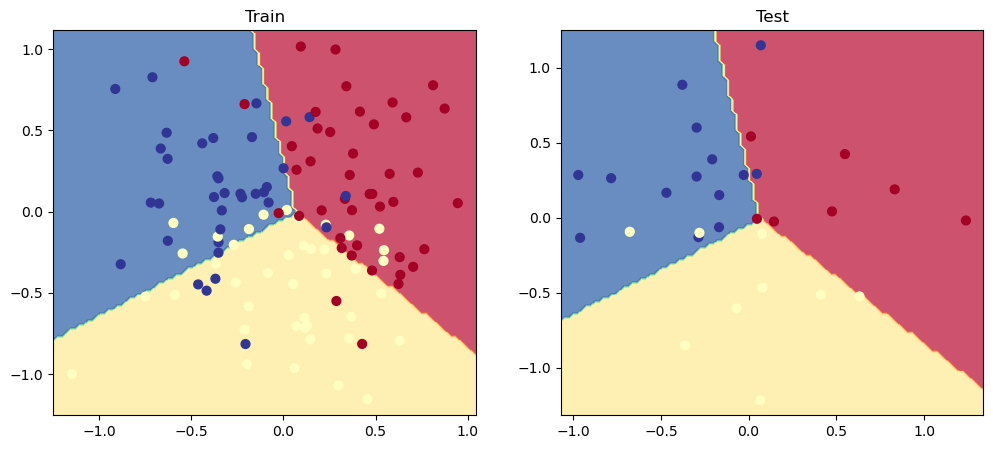

In [17]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()


In [31]:
# apply noliner model by multilayer Perceptron
class MLP(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim,output_dim)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight,gain = nn.init.calculate_gain('relu'))
    def forward(self,x_in,apply_Softmax = False):
        a1 = F.relu(self.fc1(x_in))
        a1 = self.dropout1(a1)
        y_pred = self.fc2(a1)

        if apply_Softmax:
            y_pred = F.softmax(y_pred,dim=1)

        return y_pred

In [32]:
model = MLP(
    input_dim=args.dimensions,
    hidden_dim=args.num_hidden_units,
    output_dim=args.num_classes
)
print(model.named_modules)
print(model.named_parameters)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=200, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=200, out_features=3, bias=True)
)>
<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=200, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=200, out_features=3, bias=True)
)>


In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters()
                      ,lr = args.learning_rate,weight_decay=args.lamda_l2)

In [34]:
for t in range(args.num_epochs):
    y_pred = model(X_train)
    _,predictions = y_pred.max(dim=1)
    accuracy = get_Accuracy(y_pred=predictions.long(),y_target=y_train)

    loss = loss_fn(y_pred,y_train)

    if t%10 == 0:
        print("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t,loss,accuracy
        ))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

epoch: 00 | loss: 1.1334 | accuracy: 33.3%
epoch: 10 | loss: 11.7371 | accuracy: 65.0%
epoch: 20 | loss: 1.8909 | accuracy: 65.0%
epoch: 30 | loss: 1.0544 | accuracy: 67.5%
epoch: 40 | loss: 0.8245 | accuracy: 67.5%
epoch: 50 | loss: 0.6119 | accuracy: 76.7%
epoch: 60 | loss: 0.5327 | accuracy: 75.8%
epoch: 70 | loss: 0.5946 | accuracy: 78.3%
epoch: 80 | loss: 0.5531 | accuracy: 75.8%
epoch: 90 | loss: 0.4573 | accuracy: 78.3%
epoch: 100 | loss: 0.4544 | accuracy: 78.3%
epoch: 110 | loss: 0.5173 | accuracy: 77.5%
epoch: 120 | loss: 0.4360 | accuracy: 76.7%
epoch: 130 | loss: 0.4411 | accuracy: 78.3%
epoch: 140 | loss: 0.4957 | accuracy: 78.3%
epoch: 150 | loss: 0.6857 | accuracy: 75.0%
epoch: 160 | loss: 0.5676 | accuracy: 78.3%
epoch: 170 | loss: 0.4310 | accuracy: 79.2%
epoch: 180 | loss: 0.3934 | accuracy: 81.7%
epoch: 190 | loss: 0.3803 | accuracy: 80.8%
epoch: 200 | loss: 0.4459 | accuracy: 79.2%
epoch: 210 | loss: 0.4043 | accuracy: 82.5%
epoch: 220 | loss: 0.4075 | accuracy: 82.

In [35]:
_,pred_train = model(X_train,apply_Softmax = True).max(dim = 1)
_,pred_test = model(X_test,apply_Softmax = True).max(dim = 1)

In [36]:
train_acc = get_Accuracy(y_pred=pred_train,y_target=y_train)
test_acc = get_Accuracy(y_pred=pred_test,y_target=y_test)

In [37]:
print("train accuracy: {0:.1f}% | test accuracy: {1:.1f}%".format(train_acc,test_acc))

train accuracy: 69.2% | test accuracy: 63.3%


x_max: tensor(1.0455)
x_min: tensor(-1.2470)
y_max: tensor(1.1162)
y_min: tensor(-1.2539)
x_max: tensor(1.3389)
x_min: tensor(-1.0715)
y_max: tensor(1.2506)
y_min: tensor(-1.3156)


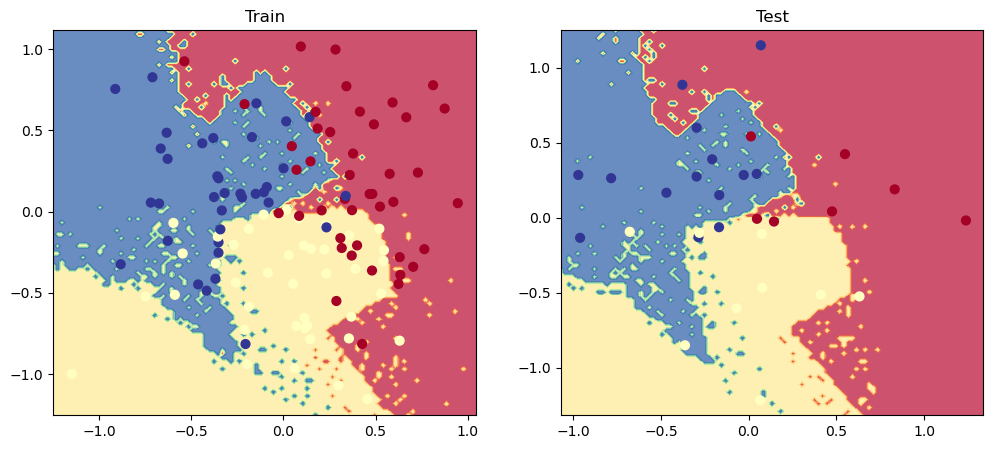

In [38]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model,X=X_train,y = y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model,X = X_test,y = y_test)
plt.show()

In [26]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

              precision    recall  f1-score   support

           0       0.50      0.71      0.59         7
           1       0.70      0.78      0.74         9
           2       0.80      0.57      0.67        14

    accuracy                           0.67        30
   macro avg       0.67      0.69      0.66        30
weighted avg       0.70      0.67      0.67        30



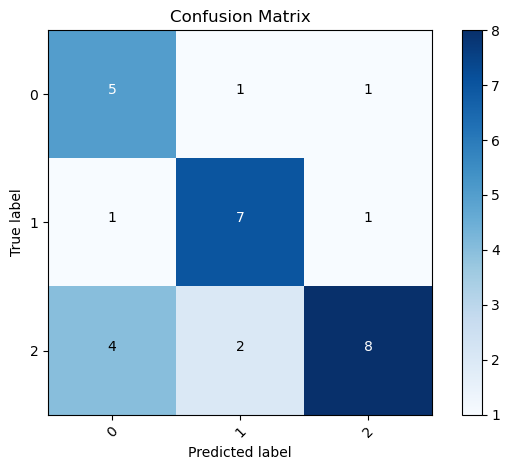

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
# the number of correct pred is shown at the daig of matrix
print (classification_report(y_test, pred_test))

In [29]:
def plot_activation_fun():
    plt.figure(figsize=(12,3))
    x = torch.arange(-5,5,0.1)

    plt.subplot(1,3,1)
    plt.title("Sigmoid Activation")
    y = torch.sigmoid(x)
    plt.plot(x.numpy(),y.numpy())

    plt.subplot(1,3,2)
    plt.title("tanh Activation")
    y = torch.tanh(x)
    plt.plot(x.numpy(),y.numpy())

    plt.subplot(1,3,3)
    plt.title("Relu Activation")
    y = F.relu(x)
    plt.plot(x.numpy(),y.numpy())

    plt.show()



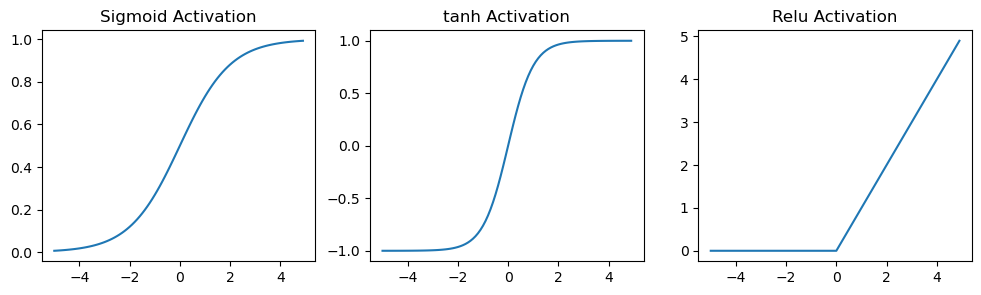

In [30]:
plot_activation_fun()